In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(DESeq2)
library(pheatmap)
library(ggplot2)
library(viridis)
library(ggpubr)
library(RColorBrewer)
library(reshape2)
library(WGCNA)
library(flashClust)
enableWGCNAThreads()
})
set.seed(123)

Allowing parallel execution with up to 127 working processes.


In [2]:
# load count data
te_hypoxia_count <- read.csv("matrix/hypoxia_vec.csv", row.names = 1, check.names = F)
te_hypoxia_count <- t(te_hypoxia_count)
colnames(te_hypoxia_count) <- unlist(strsplit(colnames(te_hypoxia_count), split = "Aligned", fixed = T))[seq(1, 2 * ncol(te_hypoxia_count), by = 2)]
te_hypoxia_count[1:6, 1:6]

,SRR10014304,SRR10014305,SRR10014306,SRR10014307,SRR10014308,SRR10014309
A1BG,30,24,24,18,37,28
A1BG-AS1,62,62,91,59,88,49
A1CF,1,0,1,1,1,0
A2M,74,26,16,36,65,172
A2M-AS1,32,18,14,15,22,45
A2ML1,2,2,1,0,0,1


In [3]:
# extract the wild type (no sirna) data
sample_wt <- c('SRR10014362','SRR10014310','SRR10014313','SRR10014374','SRR10014363','SRR10014349','SRR10014361','SRR10014324','SRR10014385','SRR10014338','SRR10014309','SRR10014402','SRR10014400','SRR10014399','SRR10014379','SRR10014360','SRR10014403','SRR10014401','SRR10014388','SRR10014364','SRR10014326','SRR10014323','SRR10014322','SRR10014321','SRR10014387','SRR10014327','SRR10014325','SRR10014320','SRR10014359','SRR10014316','SRR10014314','SRR10014312','SRR10014311','SRR10014319','SRR10014317','SRR10014315','SRR10014398','SRR10014378','SRR10014393','SRR10014391','SRR10014390','SRR10014389','SRR10014397','SRR10014395','SRR10014392')
# sample_wt <- c('SRR10014362','SRR10014310','SRR10014313','SRR10014374','SRR10014363','SRR10014349','SRR10014338','SRR10014309','SRR10014402','SRR10014400','SRR10014399','SRR10014379','SRR10014388','SRR10014364','SRR10014326','SRR10014323','SRR10014322','SRR10014321','SRR10014320','SRR10014359','SRR10014316','SRR10014314','SRR10014312','SRR10014311','SRR10014398','SRR10014378','SRR10014393','SRR10014391','SRR10014390','SRR10014389')
te_hypoxia_count_wt <- te_hypoxia_count[, sample_wt]

In [4]:
# create coldata
colData <- data.frame(row.names = sample_wt, time = factor(rep(c(1,2,3,5,7,9,12,24,48), 5)), oxygen = factor(rep(c(0.1, 1, 3, 5, 21), each = 9)))
# colData <- data.frame(row.names = sample_wt, time = factor(rep(c(1,2,3,5,7,9), 5)), oxygen = factor(rep(c(0.1, 1, 3, 5, 21), each = 6)))

In [5]:
# create DESeqDataSet and normalize
dds <- DESeqDataSetFromMatrix(countData = te_hypoxia_count_wt, colData = colData, design = ~ time + oxygen)
dds <- estimateSizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)

In [6]:
# load TE silencers and TEs in HME5
te_silencers <- read.csv("meta/TE_silencers_all_average_expression_human.csv", row.names = 1)
te_silencers <- rownames(subset(te_silencers, Down == TRUE))

te_module_hg38 <- read.csv("meta/te_module_hg38.csv", row.names = 1)
te_hme5_good <- rownames(subset(te_module_hg38, kME >= 0.3))

In [7]:
# plot TEs in HME5
cc = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))

newCols <- colorRampPalette(brewer.pal(n = 7, name = "Greens"))
annoCol1 <- newCols(length(unique(colData$oxygen)))
names(annoCol1) <- unique(colData$oxygen)

newCols <- colorRampPalette(brewer.pal(n = 7, name = "Greys"))
annoCol2 <- newCols(length(unique(colData$time)))
names(annoCol2) <- unique(colData$time)

annoCol <- list(oxygen = annoCol1, time = annoCol2)
pheatmap(log2(normalized_counts[intersect(te_hme5_good, rownames(normalized_counts)), ] + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, show_rownames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_TEs_HME5.pdf", width = 6, height = 2.5)

In [8]:
# plot all TEs
normalized_counts_good <- normalized_counts[which(rowSums(normalized_counts) > 0), ]
normalized_counts_te <- normalized_counts_good[grep(rownames(normalized_counts_good), pattern = "\\.DNA|\\.LINE|\\.SINE|\\.LTR|SVA", value = T), ]
normalized_counts_te <- normalized_counts_te[which(rowSums(normalized_counts_te) / ncol(normalized_counts_te) > 1), ]
pheatmap(log2(normalized_counts_te + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, show_rownames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_TEs_all.pdf", width = 6, height = 10)

In [9]:
# plot HIFs, TE silencers
cc = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))

newCols <- colorRampPalette(brewer.pal(n = 7, name = "Greens"))
annoCol1 <- newCols(length(unique(colData$oxygen)))
names(annoCol1) <- unique(colData$oxygen)

newCols <- colorRampPalette(brewer.pal(n = 7, name = "Greys"))
annoCol2 <- newCols(length(unique(colData$time)))
names(annoCol2) <- unique(colData$time)

annoCol <- list(oxygen = annoCol1, time = annoCol2)
pheatmap(log2(normalized_counts[c("HIF1A","EPAS1","SLC2A3","SLC2A1","NOTCH1","CXCR4","HIF3A","CXCL12","EDN1","MMP2","ZNF268","ZNF300","ZNF589","DNMT1","UHRF1","EZH2","RBBP4","RBBP7","TASOR2","TRIM28","METTL14","MKI67"), ] + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = F, show_colnames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_hif_te_silencers.pdf", width = 6, height = 3)

In [10]:
# output the normalized count matrix
write.csv(normalized_counts, "meta/normalized_counts_HUVEC_wildtype.csv")

In [11]:
# draw cell markers of pre-HECs
celltype_markers <- read.csv("meta/celltype_markers_MAST_human.csv", row.names = 1)
celltype_markers_significant <- subset(celltype_markers, avg_log2FC >= 0.5 & p_val_adj <= 0.05)
celltype_markers_prehec <- celltype_markers_significant[celltype_markers_significant$cluster == "pre-HEC", "gene"]
celltype_markers_prehec <- intersect(celltype_markers_prehec, rownames(normalized_counts))
celltype_markers_prehec <- unique(c(celltype_markers_prehec, c('MIR99AHG','MIR4435-2HG','MIR100HG','MIR503HG')))
normalized_counts_prehec <- normalized_counts[celltype_markers_prehec, ]
normalized_counts_prehec <- normalized_counts_prehec[which(rowSums(normalized_counts_prehec) > 0), ]
pheatmap(log2(normalized_counts_prehec + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, , filename = "figure/pheatmap_pre-HEC_markers.pdf", width = 10, height = 40)

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE


TRUE 
  45 

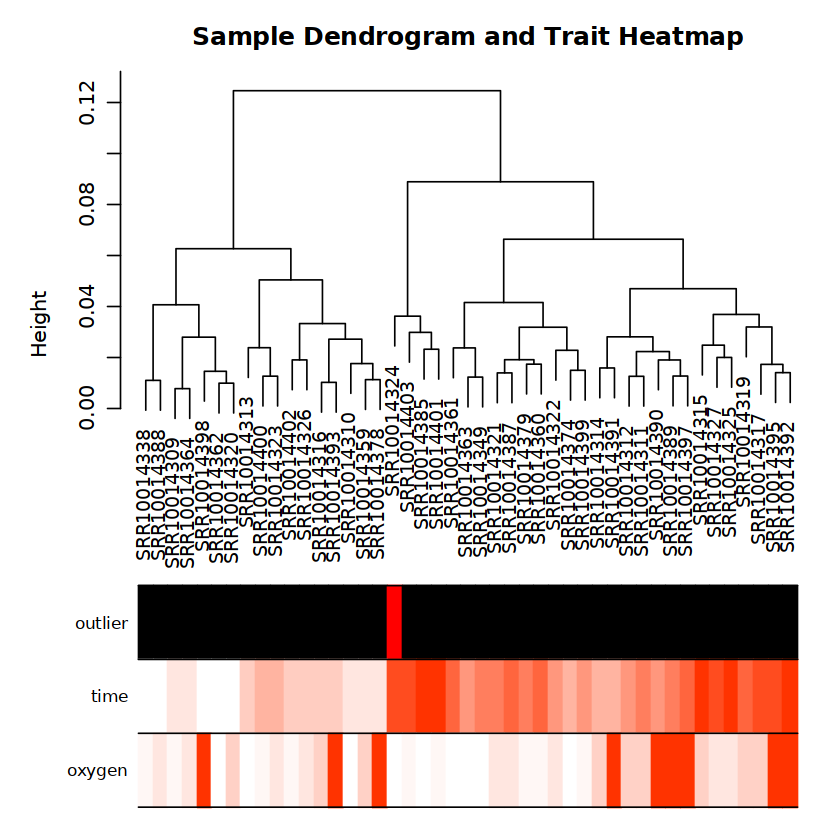

In [12]:
# WGCNA analysis of pre-HEC markers in HUVEC data
# log normalize the data
datExpr <- as.data.frame(t(log2(normalized_counts_prehec + 1)))
gsg <- goodSamplesGenes(datExpr, verbose = 3)
gsg$allOK

# load the trait data
datTraits <- colData
datTraits$time <- as.numeric(datTraits$time)
datTraits$oxygen <- as.numeric(as.character(datTraits$oxygen))
table(rownames(datTraits) == rownames(datExpr))

# cluster the samples
A <- adjacency(t(datExpr), type = "signed")
k <- as.numeric(apply(A, 2, sum)) - 1
Z.k <- scale(k)
thresholdZ.k <- - 2.5
outlierColor <- ifelse(Z.k < thresholdZ.k, "red", "black")
sampleTree <- flashClust(as.dist(1 - A), method = "average")

# sample dendrogram
traitColors <- data.frame(numbers2colors(datTraits, signed = FALSE))
dimnames(traitColors)[[2]] <- paste(names(datTraits))
datColors <- data.frame(outlier = outlierColor, traitColors)
plotDendroAndColors(sampleTree, groupLabels = names(datColors), colors = datColors, main = "Sample Dendrogram and Trait Heatmap")

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.54000  8.580          0.962 121.000  121.0000 133.00
2      2  0.00386  0.277          0.543  70.400   69.2000  88.60
3      3  0.22200 -1.180          0.684  44.700   43.2000  66.00
4      4  0.24900 -0.925          0.814  30.200   29.1000  51.90
5      5  0.30000 -0.840          0.893  21.500   20.1000  42.30
6      6  0.42300 -0.881          0.938  15.800   14.7000  35.20
7      7  0.54000 -0.942          0.972  12.000   10.7000  29.90
8      8  0.65800 -1.040          0.946   9.390    8.1300  25.80
9      9  0.66600 -1.150          0.838   7.480    6.2800  22.50
10    10  0.73000 -1.110          0.942   6.070    4.9000  19.80
11    12  0.81200 -1.150          0.953   4.160    3.0800  15.80
12    14  0.83600 -1.210          0.937   2.990    1.9900  12.90
13    16  0.85300 -1.260          0.904   2.220    1.3000  10.80
14    18  0.88200 -1.290          0.947   1.700    0.8640   9.20
15    20  0.81200 -1.390 

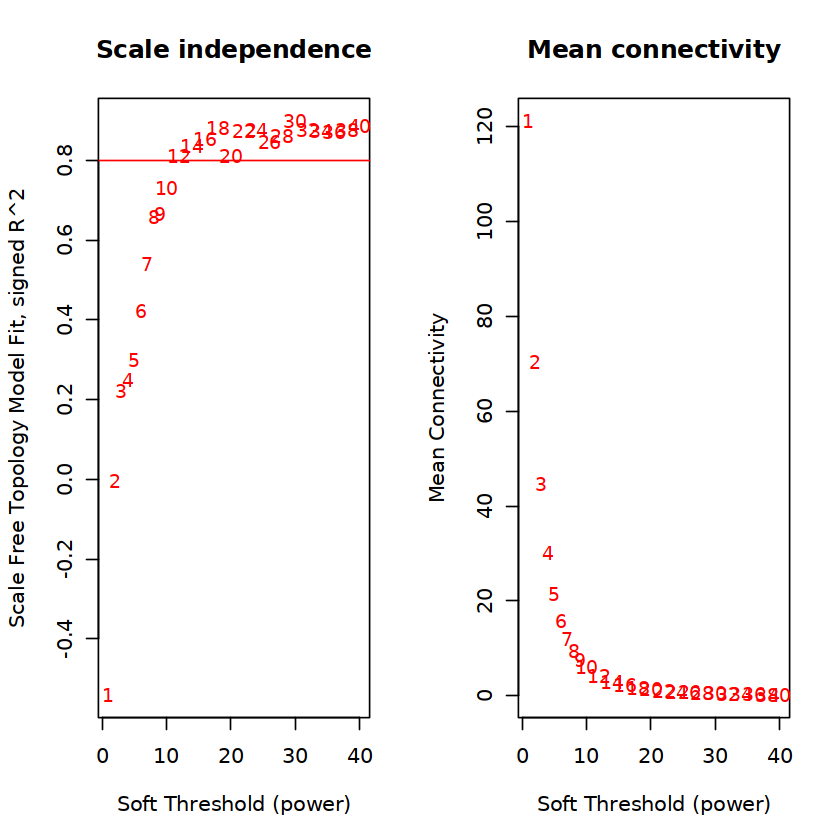

In [13]:
#Remove outlying samples
remove.samples <- Z.k < thresholdZ.k | is.na(Z.k)
datExprOut <- datExpr[!remove.samples,]
datTraitsOut <- datTraits[!remove.samples,]
datExpr <- datExprOut
datTraits <- datTraitsOut

# choose soft threshold
powers <- c(c(1:10), seq(from = 12, to = 40, by = 2))
sft <- pickSoftThreshold(datExpr, dataIsExpr = TRUE, powerVector = powers, corFnc = cor, corOptions = list(use = 'p'), networkType = "signed")
#p lot softPower results
par(mfrow = c(1, 2))
cex1 = 0.9
# scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[, 1], -sign(sft$fitIndices[, 3])*sft$fitIndices[, 2], xlab = "Soft Threshold (power)", ylab = "Scale Free Topology Model Fit, signed R^2", type = "n", main = paste("Scale independence"))
text(sft$fitIndices[, 1], -sign(sft$fitIndices[, 3])*sft$fitIndices[, 2], labels = powers, cex = cex1, col = "red")
abline(h = 0.80,col = "red")
# mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[, 1], sft$fitIndices[, 5], xlab = "Soft Threshold (power)", ylab = "Mean Connectivity", type = "n", main = paste("Mean connectivity"))
text(sft$fitIndices[, 1], sft$fitIndices[, 5], labels = powers, cex = cex1, col = "red")

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
 ..done.


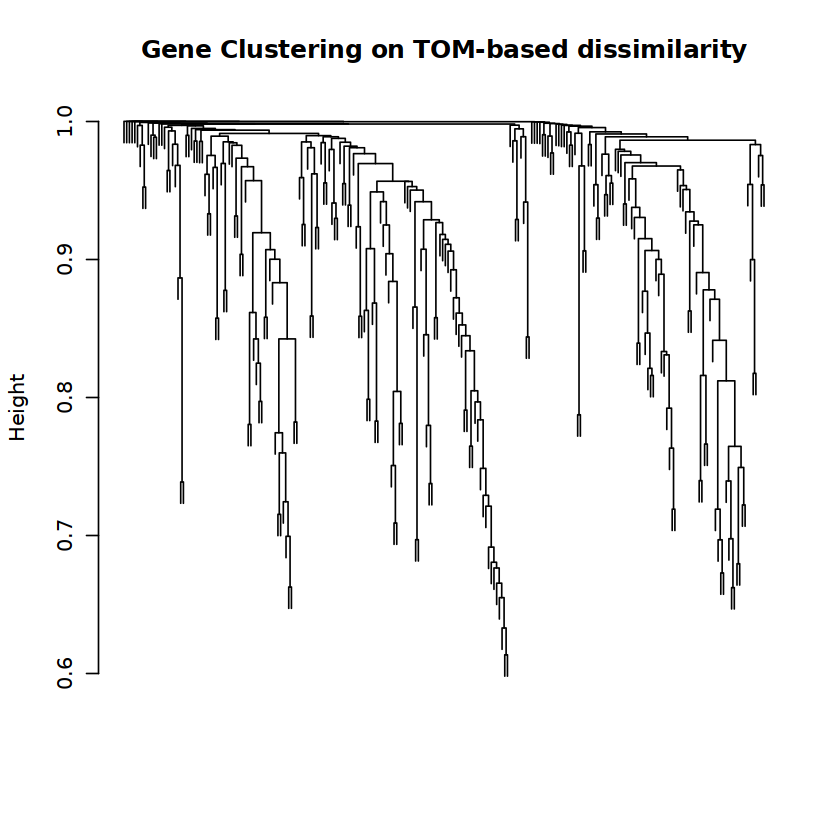

 mergeCloseModules: Merging modules whose distance is less than 0
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 6 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 6 module eigengenes in given set.


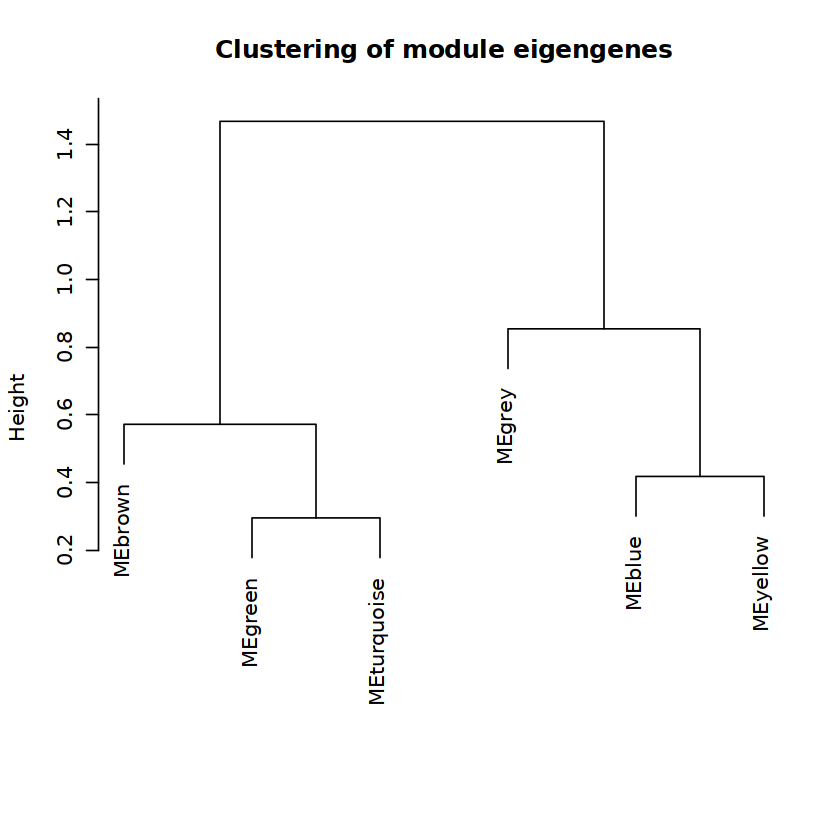

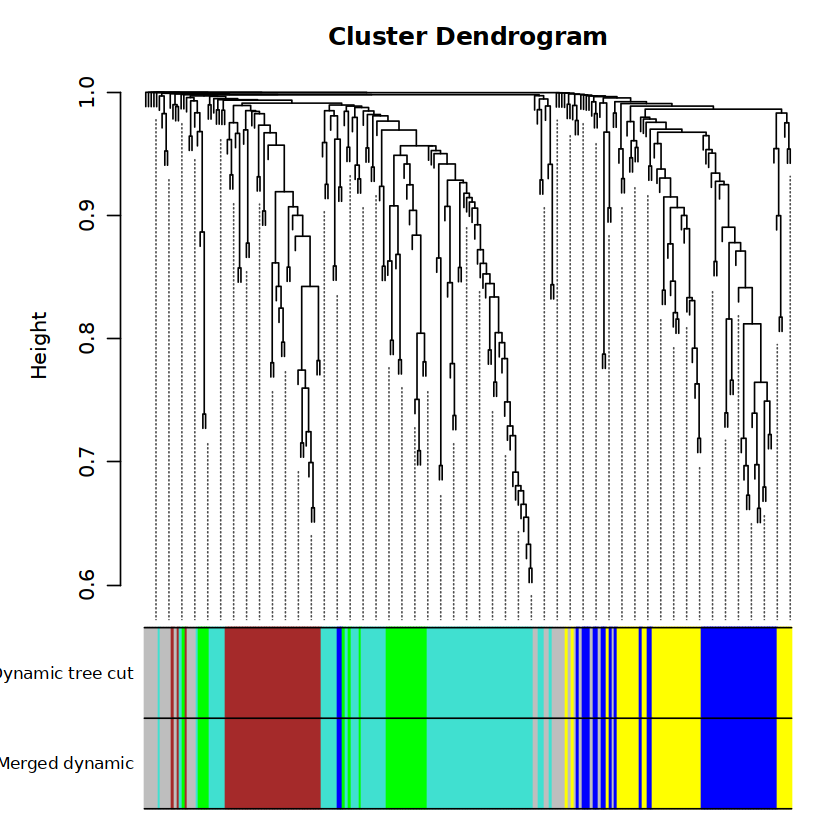

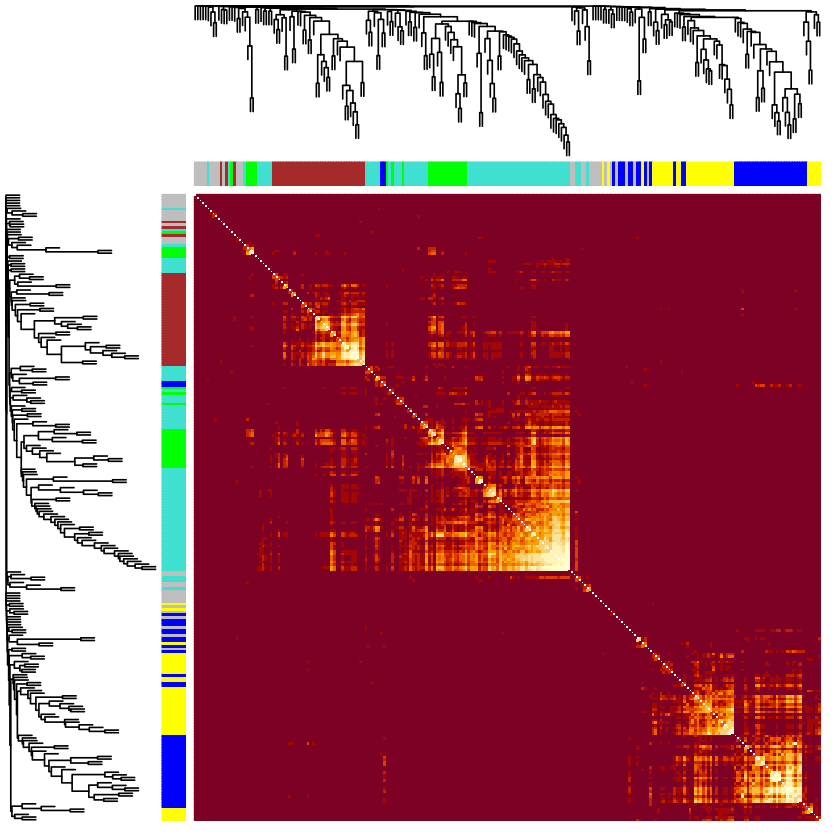

In [14]:
# generate adjacency matrix
softPower <- 18
adjacency <- adjacency(datExpr, power = softPower, type = "signed")

# generate TOM matrix
TOM <- TOMsimilarity(adjacency, TOMType = "signed")
dissTOM <- 1 - TOM

# gene cluster dendrogram
geneTree <- flashClust(as.dist(dissTOM), method = "average")
par(mfrow = c(1, 1))
plot(geneTree, xlab = "", sub = "", main = "Gene Clustering on TOM-based dissimilarity", labels = FALSE, hang = 0.04)

minModuleSize <- 15

dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM, deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = minModuleSize)
dynamicColors <- labels2colors(dynamicMods)
MEList <- moduleEigengenes(datExpr, colors = dynamicColors, softPower = softPower)
MEs <- MEList$eigengenes
MEDiss <- 1 - cor(MEs)
METree <- flashClust(as.dist(MEDiss), method = "average")

# module cluster dendrogram
plot(METree, main = "Clustering of module eigengenes", xlab = "", sub = "")
# merge moudles
MEDissThres <- 0.00 #not to merge
merge <- mergeCloseModules(datExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)
mergedColors <- merge$colors
mergedMEs <- merge$newMEs

# module grouping
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors), c("Dynamic tree cut", "Merged dynamic"), dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05)
moduleColors <- mergedColors
colorOrder <- c("grey", standardColors(50))
moduleLabels <- match(moduleColors, colorOrder) - 1
MEs <- mergedMEs

# connectivity calculation
allDegrees <- intramodularConnectivity(adjacency, dynamicColors)
allDegrees <- allDegrees[order(allDegrees$kTotal), ]
allDegrees <- data.frame(GeneID = rownames(allDegrees), allDegrees)

# output module members
module_colors = setdiff(unique(dynamicColors), "grey")
for(color in module_colors){
    module_genes = colnames(datExpr)[which(dynamicColors == color)]
    write.table(module_genes, paste("meta/module_", color, ".txt", sep=""), sep="\t", row.names=FALSE, col.names=FALSE, quote=FALSE)
}

# TOM plot
#set the diagonal of the dissimilarity to NA 
diag(dissTOM) = NA
#Visualize the Tom plot. Raise the dissimilarity matrix to a power  to bring out the module structure
TOMplot(dissTOM^4, geneTree, as.character(dynamicColors))

In [16]:
# plot module genes
module_genes = colnames(datExpr)[which(dynamicColors == "blue")]
pheatmap(log2(normalized_counts[module_genes, ] + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_prehec_markers_in_huvec_blue.pdf", width = 6, height = 6)
module_genes = colnames(datExpr)[which(dynamicColors == "brown")]
pheatmap(log2(normalized_counts[module_genes, ] + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_prehec_markers_in_huvec_brown.pdf", width = 6, height = 5.3)
module_genes = colnames(datExpr)[which(dynamicColors == "green")]
pheatmap(log2(normalized_counts[module_genes, ] + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_prehec_markers_in_huvec_green.pdf", width = 6, height = 3.5)
module_genes = colnames(datExpr)[which(dynamicColors == "turquoise")]
pheatmap(log2(normalized_counts[module_genes, ] + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_prehec_markers_in_huvec_turquoise.pdf", width = 6, height = 8.9)
module_genes = colnames(datExpr)[which(dynamicColors == "yellow")]
pheatmap(log2(normalized_counts[module_genes, ] + 1), scale = "row", annotation_col = colData, cluster_cols = F, cluster_rows = T, show_colnames = F, border_color = "grey90", color = cc(100), annotation_colors = annoCol, filename = "figure/pheatmap_prehec_markers_in_huvec_yellow.pdf", width = 6, height = 5)

In [17]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] flashClust_1.01-2           WGCNA_1.72-1               
 [3] fastcluster_1.2.3           dynamicTreeCut_1.63-1      
 [5] reshape2_1.4.4              RColorBrewer_1.1-3         
 [7] ggpubr_0.6.0                viridis_0.6.2              
 [9] viridisLite_0.4.1           ggplot2_3.4.2              
[11] pheatmap_1.0.12             DESeq2_1.38.3              
[13] SummarizedExperiment_1.28.0 Biob